In [9]:
!pip install opencv-contrib-python


7 fixations overlap 166.000s ± 1.000s.


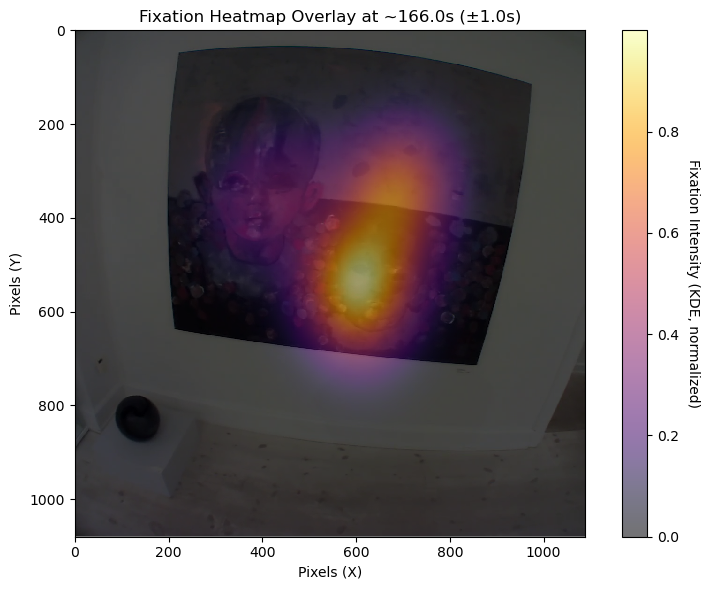

In [8]:
# === Requirements ===
# pip install numpy pandas matplotlib scipy opencv-python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import cv2

# ----------------------------
# User inputs
# ----------------------------
fix_csv   = r"C:\Users\graka\Downloads\anna_walking_upstairs-30447eee\fixations.csv"    # <-- change this
video_mp4 = r"C:\Users\graka\Downloads\anna_walking_upstairs-30447eee\18510f6a_0.0-490.603.mp4" # <-- change this

center_time_s = 166.0   # center time (seconds) where you want the heatmap
window_s      = 1.0     # include fixations overlapping [t-1.0, t+1.0] seconds
grid_res      = 200     # heatmap grid resolution (e.g., 200x200)
alpha_overlay = 0.55    # transparency of heatmap overlay
bw_method     = None    # KDE bandwidth (None lets scipy choose; or try 0.2, 0.3, etc.)

# ----------------------------
# 1) Load fixations and standardize columns
# ----------------------------
df = pd.read_csv(fix_csv)

rename_map = {
    'fixation id': 'fixation_id',
    'start timestamp [ns]': 'start_ns',
    'end timestamp [ns]': 'end_ns',
    'duration [ms]': 'duration_ms',
    'fixation x [px]': 'cx_px',
    'fixation y [px]': 'cy_px',
    'azimuth [deg]': 'azimuth_deg',
    'elevation [deg]': 'elevation_deg',
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Basic cleaning
df = df.dropna(subset=['cx_px', 'cy_px', 'start_ns', 'end_ns', 'duration_ms']).copy()

# Convert timestamps to seconds relative to the first row (so video alignment is simpler)
t0_ns = df['start_ns'].iloc[0]
df['start_s'] = (df['start_ns'] - t0_ns) / 1e9
df['end_s']   = (df['end_ns']   - t0_ns) / 1e9

# ----------------------------
# 2) Select fixations that overlap the [center_time_s - window_s, center_time_s + window_s]
# A fixation "overlaps" the window if any part of it falls inside the time range.
# ----------------------------
t1 = center_time_s - window_s
t2 = center_time_s + window_s
mask = (df['start_s'] <= t2) & (df['end_s'] >= t1)
sub = df.loc[mask].copy()

if sub.empty:
    print(f'No fixations found overlapping {center_time_s:.3f}s ± {window_s:.3f}s.')
else:
    print(f'{len(sub)} fixations overlap {center_time_s:.3f}s ± {window_s:.3f}s.')

# ----------------------------
# 3) Extract the video frame at center_time_s
# ----------------------------
cap = cv2.VideoCapture(video_mp4)
if not cap.isOpened():
    raise RuntimeError(f'Could not open video: {video_mp4}')

fps   = cap.get(cv2.CAP_PROP_FPS)
nfrm  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
dur_s = nfrm / max(fps, 1e-6)

# Move to the requested time (clamped inside duration)
seek_time_s = float(np.clip(center_time_s, 0, max(dur_s - 1e-3, 0)))
cap.set(cv2.CAP_PROP_POS_MSEC, seek_time_s * 1000.0)
ok, frame_bgr = cap.read()
cap.release()

if not ok:
    raise RuntimeError('Could not read frame at requested time.')

# Convert BGR->RGB for matplotlib
frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
H, W = frame_rgb.shape[:2]

# ----------------------------
# 4) Build KDE heatmap over pixel coordinates
#    (Optionally weight by fixation duration, so longer fixations contribute more intensity)
# ----------------------------
if not sub.empty:
    pts = sub[['cx_px', 'cy_px']].to_numpy().T  # shape = 2 x N
    # Clip to frame bounds to avoid out-of-bounds issues
    pts[0] = np.clip(pts[0], 0, W-1)
    pts[1] = np.clip(pts[1], 0, H-1)

    # Optional weighting by duration (ms)
    weights = sub['duration_ms'].to_numpy()
    weights = np.maximum(weights, 1.0)  # avoid zeros

    # Build KDE (if scipy version supports weights; most recent do)
    try:
        kde = gaussian_kde(pts, weights=weights, bw_method=bw_method)
    except TypeError:
        # Fallback: no weights supported -> use unweighted KDE
        kde = gaussian_kde(pts, bw_method=bw_method)

    # Evaluate KDE on a grid
    xs = np.linspace(0, W, grid_res)
    ys = np.linspace(0, H, grid_res)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.vstack([xx.ravel(), yy.ravel()])   # shape 2 x (grid_res^2)
    zz = kde(grid).reshape(xx.shape)

    # Normalize heatmap to [0,1] for plotting transparency and colorbar scaling
    zz = (zz - zz.min()) / (zz.max() - zz.min() + 1e-12)
else:
    # If no fixations, create a zero heatmap
    xs = np.linspace(0, W, grid_res)
    ys = np.linspace(0, H, grid_res)
    xx, yy = np.meshgrid(xs, ys)
    zz = np.zeros_like(xx)

# ----------------------------
# 5) Plot: frame + heatmap overlay + colorbar
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 6))
im_frame = ax.imshow(frame_rgb, interpolation='nearest')

# Overlay heatmap. Use origin='upper' so (0,0) is top-left to match image coordinates.
im_heat = ax.imshow(
    zz,
    extent=[0, W, H, 0],
    origin='upper',
    alpha=alpha_overlay
)

# Choose a perceptual colormap (you can try 'inferno', 'magma', 'viridis')
im_heat.set_cmap('inferno')

# Add colorbar showing heat intensity
cbar = fig.colorbar(im_heat, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Fixation Intensity (KDE, normalized)', rotation=270, labelpad=15)

ax.set_title(f'Fixation Heatmap Overlay at ~{center_time_s:.1f}s (±{window_s:.1f}s)')
ax.set_xlim(0, W)
ax.set_ylim(H, 0)  # invert y to keep origin at top-left
ax.set_xlabel('Pixels (X)')
ax.set_ylabel('Pixels (Y)')
plt.tight_layout()
plt.show()


P1 fixations overlapping [0, 5] s: 15
P2 fixations overlapping [0, 5] s: 9


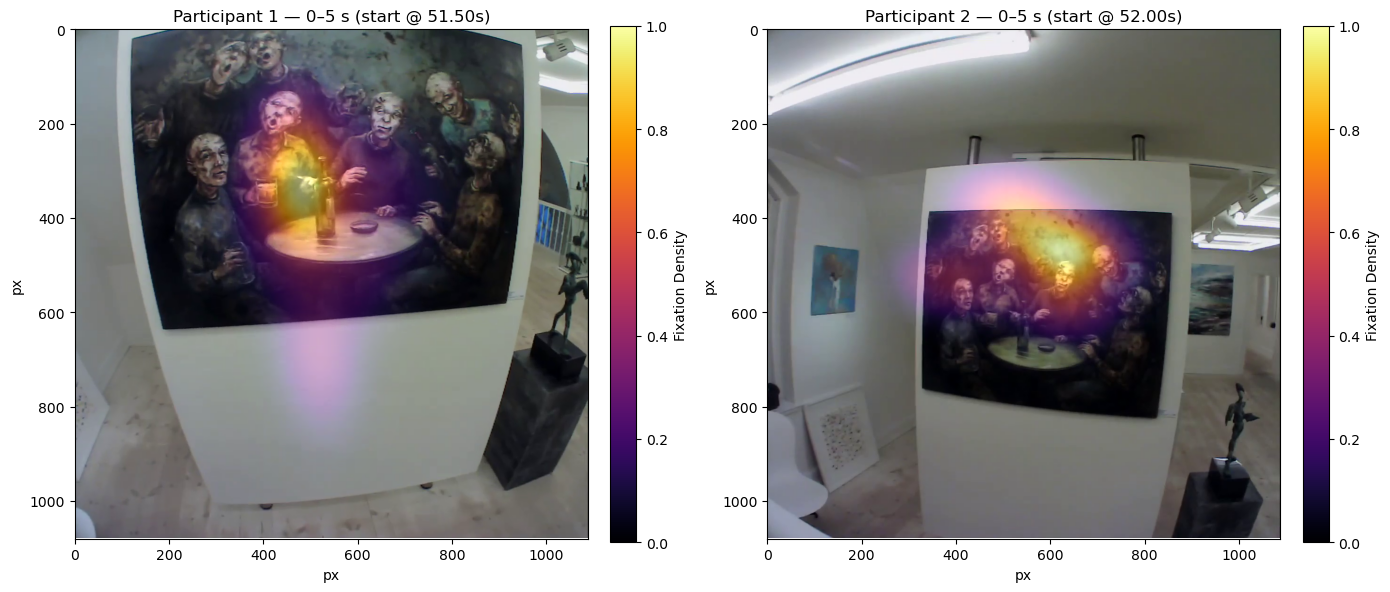

In [3]:
# Requirements:
# pip install numpy pandas opencv-python scipy matplotlib

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from pathlib import Path

# ------------------------
# INPUTS — change these
# ------------------------
fix_csv_1    = r"C:\Users\graka\Downloads\steven_walking_upstairs-71fadeee\fixations.csv"
video_path_1 = r"C:\Users\graka\Downloads\steven_walking_upstairs-71fadeee\0a5966ca_0.0-197.634.mp4"     # set same path for both if same video file
anchor_abs_s_1 = 51.5                           # P1 start

fix_csv_2    = r"C:\Users\graka\Downloads\susan_walking_upstairs-169f9eee\fixations.csv"
video_path_2 = r"C:\Users\graka\Downloads\susan_walking_upstairs-169f9eee\215f79e6_0.0-302.385.mp4"
anchor_abs_s_2 = 52.0                           # P2 start

# Analysis window (relative to each start)
win_start_s  = 0.0
win_end_s    = 5.0

# Heatmap settings
heat_grid            = 180    # grid resolution for KDE
heat_alpha           = 0.55   # overlay transparency
use_duration_weights = True   # weight by fixation duration
min_kde_points       = 8      # fallback to splat+blur if fewer points
fallback_sigma_px    = 40     # blur strength for fallback heat
cmap_name            = 'inferno'

# ------------------------
# Helpers
# ------------------------
def load_fixations(csv_path):
    df = pd.read_csv(csv_path)
    ren = {
        'fixation id': 'fixation_id',
        'start timestamp [ns]': 'start_ns',
        'end timestamp [ns]': 'end_ns',
        'duration [ms]': 'duration_ms',
        'fixation x [px]': 'cx_px',
        'fixation y [px]': 'cy_px',
    }
    df = df.rename(columns={k: v for k, v in ren.items() if k in df.columns})
    need = ['start_ns','end_ns','cx_px','cy_px']
    if any(c not in df.columns for c in need):
        raise ValueError(f"Missing columns in {csv_path}. Need: {need}")
    df = df.dropna(subset=need).copy()
    # make absolute seconds relative to first timestamp in this file
    t0_ns = df['start_ns'].min()
    df['start_s_abs'] = (df['start_ns'] - t0_ns) / 1e9
    df['end_s_abs']   = (df['end_ns']   - t0_ns) / 1e9
    return df

def grab_frame_at_time(video_path, time_s):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open {video_path}")
    cap.set(cv2.CAP_PROP_POS_MSEC, max(0.0, time_s) * 1000.0)
    ok, frame_bgr = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Could not read frame at {time_s:.3f}s from {video_path}")
    return cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

def select_window(df, anchor_abs_s, win0, win1):
    """Add relative time (t_rel) w.r.t. anchor, select fixations overlapping [win0, win1]."""
    df = df.copy()
    df['t_rel_start'] = df['start_s_abs'] - anchor_abs_s
    df['t_rel_end']   = df['end_s_abs']   - anchor_abs_s
    mask = (df['t_rel_end'] >= win0) & (df['t_rel_start'] <= win1)
    return df.loc[mask].copy()

def build_heat_layer(H, W, pts_xy, weights=None, grid=180, min_kde_pts=8,
                     fallback_sigma=40, cmap=cv2.COLORMAP_INFERNO):
    """
    Return color heatmap (H,W,3) in BGR, normalized [0..255].
    Uses KDE when enough points; otherwise splat+blur fallback.
    pts_xy: Nx2 pixel coords (x,y).
    """
    pts_xy = np.asarray(pts_xy, dtype=float)
    if pts_xy.size == 0:
        return np.zeros((H, W, 3), dtype=np.uint8)

    xs = np.clip(pts_xy[:,0], 0, W-1)
    ys = np.clip(pts_xy[:,1], 0, H-1)
    N  = len(xs)

    # try KDE
    heat_color = None
    if N >= min_kde_pts:
        try:
            pts2xN = np.vstack([xs, ys])
            kde = gaussian_kde(pts2xN, weights=None if weights is None else np.asarray(weights, float))
            gx = np.linspace(0, W, grid)
            gy = np.linspace(0, H, grid)
            xx, yy = np.meshgrid(gx, gy)
            zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
            zz = (zz - zz.min()) / (zz.max() - zz.min() + 1e-12)
            heat_small = (zz * 255).astype(np.uint8)
            heat_color = cv2.applyColorMap(heat_small, cmap)
            heat_color = cv2.resize(heat_color, (W, H), interpolation=cv2.INTER_CUBIC)
        except Exception:
            heat_color = None

    if heat_color is None:
        # splat + blur fallback
        heat = np.zeros((H, W), dtype=np.float32)
        if weights is None:
            w = np.ones(N, dtype=np.float32)
        else:
            w = np.asarray(weights, float)
            w = (w - w.min()) / (w.max() - w.min() + 1e-12)
            w = 0.5 + 1.5 * w
        r = max(2, fallback_sigma // 3)
        for x, y, ww in zip(xs.astype(int), ys.astype(int), w):
            cv2.circle(heat, (x, y), r, float(ww), -1, lineType=cv2.LINE_AA)
        k = max(3, int(fallback_sigma) | 1)
        heat = cv2.GaussianBlur(heat, (k, k), fallback_sigma)
        heat = heat / (heat.max() + 1e-12)
        heat_u8 = (heat * 255).astype(np.uint8)
        heat_color = cv2.applyColorMap(heat_u8, cmap)

    return heat_color

def overlay_heat_on_frame(frame_rgb, heat_bgr, alpha=0.55):
    frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
    blended = cv2.addWeighted(frame_bgr, 1.0, heat_bgr, alpha, 0)
    return cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

# ------------------------
# Load data
# ------------------------
df1 = load_fixations(fix_csv_1)
df2 = load_fixations(fix_csv_2)

# Select each participant's 0–5 s window relative to their own anchor
sub1 = select_window(df1, anchor_abs_s_1, win_start_s, win_end_s)
sub2 = select_window(df2, anchor_abs_s_2, win_start_s, win_end_s)

print(f"P1 fixations overlapping [0, 5] s: {len(sub1)}")
print(f"P2 fixations overlapping [0, 5] s: {len(sub2)}")

# Grab frames exactly at each start
frame1 = grab_frame_at_time(video_path_1, anchor_abs_s_1)
frame2 = grab_frame_at_time(video_path_2, anchor_abs_s_2)
H1, W1 = frame1.shape[:2]
H2, W2 = frame2.shape[:2]

# Build heat layers
w1 = sub1['duration_ms'].values if (use_duration_weights and 'duration_ms' in sub1.columns) else None
w2 = sub2['duration_ms'].values if (use_duration_weights and 'duration_ms' in sub2.columns) else None

heat1_bgr = build_heat_layer(H1, W1, sub1[['cx_px','cy_px']].values,
                             weights=w1, grid=heat_grid,
                             min_kde_pts=min_kde_points,
                             fallback_sigma=fallback_sigma_px,
                             cmap=cv2.COLORMAP_INFERNO)
heat2_bgr = build_heat_layer(H2, W2, sub2[['cx_px','cy_px']].values,
                             weights=w2, grid=heat_grid,
                             min_kde_pts=min_kde_points,
                             fallback_sigma=fallback_sigma_px,
                             cmap=cv2.COLORMAP_INFERNO)

# Blend onto frames
blend1 = overlay_heat_on_frame(frame1, heat1_bgr, alpha=heat_alpha)
blend2 = overlay_heat_on_frame(frame2, heat2_bgr, alpha=heat_alpha)

# ------------------------
# Plot side-by-side with colorbars

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Convert heatmaps to grayscale intensity (for colorbar scaling)
def heat_intensity(heat_bgr):
    gray = cv2.cvtColor(heat_bgr, cv2.COLOR_BGR2GRAY)
    return gray / 255.0  # normalize 0–1

heat1_intensity = heat_intensity(heat1_bgr)
heat2_intensity = heat_intensity(heat2_bgr)

# Plot Participant 1
im1 = axes[0].imshow(blend1)
axes[0].imshow(heat1_intensity, cmap='inferno', alpha=0)  # hidden reference for colorbar
axes[0].set_title(f"Participant 1 — 0–5 s (start @ {anchor_abs_s_1:.2f}s)")
axes[0].set_xlim([0, W1]); axes[0].set_ylim([H1, 0])
axes[0].set_xlabel("px"); axes[0].set_ylabel("px")
cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap='inferno'), ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label("Fixation Density")

# Plot Participant 2
im2 = axes[1].imshow(blend2)
axes[1].imshow(heat2_intensity, cmap='inferno', alpha=0)
axes[1].set_title(f"Participant 2 — 0–5 s (start @ {anchor_abs_s_2:.2f}s)")
axes[1].set_xlim([0, W2]); axes[1].set_ylim([H2, 0])
axes[1].set_xlabel("px"); axes[1].set_ylabel("px")
cbar2 = plt.colorbar(plt.cm.ScalarMappable(cmap='inferno'), ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label("Fixation Density")

plt.tight_layout()
plt.show()

